In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import sys

from model.model import MV_MODEL

from dataset.TimeDataset import TimeDataset

from torch.utils.data import DataLoader

#from preprocess.synthetic.multi_view_dataset import *
from data.synthetic.multi_view_sines import *
#from utils.data_utils import get_MV_Training_Data
from utils.time_utils import print_train_time
from utils.plot_utils import plot_losses
from utils.plot_utils import plot_multi_view_data_forecasted
from utils.plot_utils import plot_single_view_data_forecasted
from utils.generic_utils import create_directory
from utils.generic_utils import regenerate_data

from constants.hyper_params import *

In [2]:
device = torch.device('cpu')
print('Device : ',device)

Device :  cpu


In [3]:
import random
    
seed = random.randint(0, 100)
#seed = 40 (working seeds)
#seed = 59 for SYN with rand initialization, 51 for SYN with zero initialization
seed = 1
print('1. seed : ',seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

1. seed :  1


In [4]:
#-------- Acquiring the Multi-View Time Series Data

#MVTS_View_Wise_Data = get_MV_Training_Data()
#MVTS_View_Wise_Data = get_dataset()
#MVTS_View_Wise_Data = Sine_multi_view()
MVTS_View_Wise_Data = multi_view_sines_set1()
sequence_length = MVTS_View_Wise_Data[0].shape[1]
num_sequences = sequence_length - window_size + 1
print("Seq Length : ",sequence_length,'; Num_Sequences : ',num_sequences)

Seq Length :  10000 ; Num_Sequences :  9991


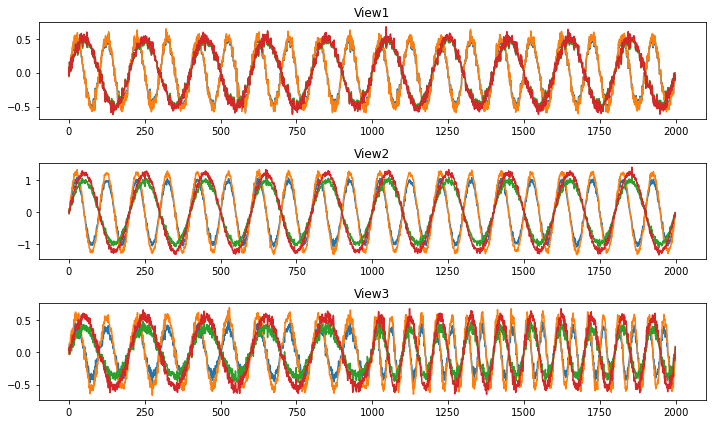

In [5]:
from utils.plot_utils import plot_multi_view_data

plot_multi_view_data(MVTS_View_Wise_Data)

In [6]:
#-------- Splitting into training and validation --------

train_seq_start = 0
train_seq_end = int((1 - val_ratio) * num_sequences)
val_seq_start = train_seq_end
val_seq_end = num_sequences - 1
print("Train : (",train_seq_start,',',train_seq_end,'); Validation : (',val_seq_start,',',val_seq_end,')')

Train : ( 0 , 7992 ); Validation : ( 7992 , 9990 )


In [7]:
train_dataset = TimeDataset(MVTS_View_Wise_Data, window_size, train_seq_start, train_seq_end) 
train_loader = DataLoader(dataset = train_dataset, batch_size=batch, shuffle=False )
val_dataset = TimeDataset(MVTS_View_Wise_Data, window_size, val_seq_start, val_seq_end) 
val_loader = DataLoader(dataset = val_dataset, batch_size=batch, shuffle=False )
print('Length of train dataloader : ',len(train_loader))
print('Length of validation dataloader : ',len(val_loader))

Length of train dataloader :  63
Length of validation dataloader :  16


In [8]:
#-------- Data properties --------------
num_views = len(MVTS_View_Wise_Data)
print('Number Of Views : ',num_views)

#-------- Getting the data view wise and the corresponding dimensions -------
Per_View_Dims = [] 

k = 0
for view in MVTS_View_Wise_Data :
 #----- Number Of Sensors per view -----
 N = view.shape[0]
 Per_View_Dims.append(N)

Number Of Views :  3


In [9]:
#------ Model, Loss, Optimizer Initialization --------------
#mv_model = MV_MODEL(window_size, window_size//2,  Per_View_Dims).to(device) #7, 
mv_model = MV_MODEL(window_size, Per_View_Dims)
mv_model = mv_model.double()

criterion = nn.MSELoss()
optimizer = optim.SGD(mv_model.parameters(), lr=learning_rate)

In [10]:
l = r"lamda1 : {}; lamda2 : {}; lamda3 : {}; lamda4 : {}; lamda5 : {}; ".format(lamdas[0],lamdas[1],lamdas[2],lamdas[3],lamdas[4])
print(l)

lamda1 : 1; lamda2 : 1; lamda3 : 1; lamda4 : 0; lamda5 : 0; 


In [11]:
#---- Losses list to be plotted towards the end of training
train_loss_list = []
train_pred_loss_list = []
train_recons_loss_list = []
view_recons_loss_list = []
norms_list = []

losses = ()

In [12]:
print('Initial View Relationships : ') #,file=F
print(mv_model.view_attn) #,file=F
print('Initial Per View Relationships : ') 
for per_view_attention in mv_model.per_view_attns:
  print(per_view_attention)

Initial View Relationships : 
Parameter containing:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64, requires_grad=True)
Initial Per View Relationships : 
Parameter containing:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=torch.float64, requires_grad=True)


In [13]:
start_time=time.time()

for epoch in range(num_epochs):
 
   #Set the model to training mode
   mv_model.train()
 
   h_prev = []
 
   for idx, (x_curr, y) in enumerate(train_loader):   
        
      if idx == 0:
        for k in range(num_views):
          h_prev.append(x_curr[k].clone().detach())
      else :
          
        h_curr, x_pred, z, z_ = mv_model(h_prev, x_curr) 
        losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas)  
        #losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas, device) #z_, 
        #break
        
        total_loss = losses[3]
          
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        mv_model.zero_diagonal()
        
        h_prev = []
        for k in range(num_views):
          h_prev.append(h_curr[k].clone().detach())
        
   train_recons_loss_list.append(losses[0].item())
   view_recons_loss_list.append(losses[1].item())   
   train_pred_loss_list.append(losses[2].item())
   train_loss_list.append(losses[3].item())
   
   #Set the model to evaluation mode
   mv_model.eval()
 
   h_prev = []
   val_pred_data = []
   val_recons_data = []
   
   total_loss = 0.0
   val_steps = 0
   
   for idx, (x_curr, y) in enumerate(val_loader): 
      
      if idx == 0:
        for k in range(num_views):
          h_prev.append(x_curr[k].clone().detach())
      else :
          
        h_curr, x_pred, z, z_ = mv_model(h_prev, x_curr) 
        
        if len(val_pred_data) == 0:
           for k in range(num_views):
               val_pred_data.append(x_pred[k])            
               val_recons_data.append(h_curr[k])
        else:
           for k in range(num_views):
             val_pred_data[k] = torch.cat([val_pred_data[k], x_pred[k]], dim=0)
             #print('val idx : ',idx,'; recons emb : ',h_curr[k].shape)
             val_recons_data[k] = torch.cat([val_recons_data[k], h_curr[k]], dim=0)
             
        #losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas, device) #z_, 
        losses = mv_model.compute_losses(h_curr, x_curr, x_pred, y, z, z_, lamdas)
        
        #total_loss = losses[3]
        total_loss += losses[3].item()
        #total_loss += losses[2].item()
        val_steps += 1
                
        mv_model.zero_diagonal()
        
        h_prev = []
        for k in range(num_views):
          h_prev.append(h_curr[k].clone().detach())
   
   #print('Final index : ',idx)
    
   val_loss = total_loss/val_steps
   
   if val_loss < best_val_loss:   
        #torch.save(mv_model.state_dict(), 'MVL_params.pt')
        best_val_loss = val_loss
        current_patience = 0
   else:
        current_patience += 1
  
   # Early stopping with patience parameter
   if current_patience >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  
   
   if((epoch+1)%5 == 0):
     #print('------------- Epoch : ',epoch+1, '--------------')
     L1 = f'Epoch : {epoch+1}; L1 = {losses[0].item():.6f}; L2 = {losses[1].item():.6f}; L3 = {losses[2].item():.6f}; L4 = {losses[3].item():.6f}; L5 = {losses[4].item():.6f}; L6 = {losses[5].item():.6f}'
     print(L1)
     #print(L1,file=F)
     
   
#torch.save(mv_model.state_dict(), 'MVL_params.pt')
  
#----- Printing total training time ---------------
train_time = (time.time()-start_time)
print_train_time(train_time)

Epoch : 5; L1 = 0.430289; L2 = 0.100171; L3 = 0.076453; L4 = 0.606913; L5 = 0.036077; L6 = 0.392741
Epoch : 10; L1 = 0.211655; L2 = 0.052273; L3 = 0.058775; L4 = 0.322703; L5 = 0.052247; L6 = 0.554742
Epoch : 15; L1 = 0.146670; L2 = 0.044159; L3 = 0.047256; L4 = 0.238085; L5 = 0.072390; L6 = 0.654108
Epoch : 20; L1 = 0.113594; L2 = 0.048911; L3 = 0.017305; L4 = 0.179810; L5 = 0.086355; L6 = 0.680271
Epoch : 25; L1 = 0.100620; L2 = 0.049591; L3 = 0.015899; L4 = 0.166109; L5 = 0.087448; L6 = 0.691773
Epoch : 30; L1 = 0.092583; L2 = 0.052593; L3 = 0.016094; L4 = 0.161270; L5 = 0.087763; L6 = 0.705384
Epoch : 35; L1 = 0.091472; L2 = 0.047651; L3 = 0.011432; L4 = 0.150555; L5 = 0.088274; L6 = 0.717463
Epoch : 40; L1 = 0.088977; L2 = 0.047614; L3 = 0.010107; L4 = 0.146698; L5 = 0.088580; L6 = 0.728815
Epoch : 45; L1 = 0.087566; L2 = 0.046670; L3 = 0.009465; L4 = 0.143701; L5 = 0.089269; L6 = 0.740472
Epoch : 50; L1 = 0.089100; L2 = 0.042494; L3 = 0.008714; L4 = 0.140308; L5 = 0.090171; L6 = 

Epoch : 410; L1 = 0.045343; L2 = 0.043808; L3 = 0.004549; L4 = 0.093701; L5 = 0.090188; L6 = 0.985845
Epoch : 415; L1 = 0.044663; L2 = 0.044527; L3 = 0.004413; L4 = 0.093603; L5 = 0.089037; L6 = 0.987187
Epoch : 420; L1 = 0.043498; L2 = 0.045706; L3 = 0.004630; L4 = 0.093834; L5 = 0.087890; L6 = 0.987309
Epoch : 425; L1 = 0.044786; L2 = 0.044302; L3 = 0.004449; L4 = 0.093536; L5 = 0.086751; L6 = 0.989174
Epoch : 430; L1 = 0.045002; L2 = 0.043981; L3 = 0.004775; L4 = 0.093758; L5 = 0.085608; L6 = 0.989624
Epoch : 435; L1 = 0.044424; L2 = 0.044616; L3 = 0.004388; L4 = 0.093428; L5 = 0.084469; L6 = 0.991197
Epoch : 440; L1 = 0.044712; L2 = 0.044261; L3 = 0.004436; L4 = 0.093409; L5 = 0.083348; L6 = 0.992146
Epoch : 445; L1 = 0.044546; L2 = 0.044423; L3 = 0.004340; L4 = 0.093309; L5 = 0.082266; L6 = 0.993247
Epoch : 450; L1 = 0.044548; L2 = 0.044354; L3 = 0.004423; L4 = 0.093325; L5 = 0.081734; L6 = 0.994113
Epoch : 455; L1 = 0.041528; L2 = 0.047675; L3 = 0.004892; L4 = 0.094095; L5 = 0.08

### Relationship Learning Verification (Synthetic Data)

In [14]:
# Saving the validation data for plotting

Val_Pred_Data = []
Val_Recons_Data = []

for k in range(num_views):
  rows = val_pred_data[k].shape[1]

  #print('val_pred_data[k].shape : ',val_pred_data[k].shape)
  temp0 = val_pred_data[k].permute(1, 0, 2).contiguous().view(rows, -1)
  #print('temp0.shape : ',temp0.shape)
  Val_Pred_Data.append(temp0.detach().numpy())
    
  #print('val_recons_data[k].shape : ',val_recons_data[k].shape)
  #temp1 = val_recons_data[k].permute(1, 0, 2).contiguous() #.view(rows, -1)
  #temp2 = temp1.detach().numpy() 
  #print('temp2.shape : ',temp2.shape)
  #reg_data = regenerate_data(temp2)
  #print(reg_data)
  #Val_Recons_Data.append(np.array(reg_data))
  #print(Val_Recons_Data[0].shape)
  #val_recons_data[k] = val_recons_data[k].detach().numpy() 

In [15]:
# Plotting validation data

#for k in range(num_views):
    #print('MVTS_View_Wise_Data[k].shape : ',MVTS_View_Wise_Data[k].shape)
    #print('Val_Pred_Data[k].shape : ',Val_Pred_Data[k].shape)
    #print('Val_Recons_Data[k].shape : ',Val_Recons_Data[k].shape)
    #print('View ',k)
    #plot_single_view_data_forecasted(MVTS_View_Wise_Data[k], Val_Pred_Data[k], str(k)) #, Val_Recons_Data[k]

In [16]:
print('Learnt View Relationships : ') #,file=F
print(mv_model.view_attn) #,file=F
print('Learnt Per View Relationships : ') 
for per_view_attention in mv_model.per_view_attns:
  print(per_view_attention)

Learnt View Relationships : 
Parameter containing:
tensor([[ 0.0000, -0.0192,  0.0047],
        [ 0.0181,  0.0000,  0.0054],
        [ 0.0194, -0.0053,  0.0000]], dtype=torch.float64, requires_grad=True)
Learnt Per View Relationships : 
Parameter containing:
tensor([[ 0.0000,  0.1472, -0.0133, -0.0130],
        [ 0.1616,  0.0000, -0.0129, -0.0126],
        [-0.0141, -0.0135,  0.0000,  0.1713],
        [-0.0133, -0.0126,  0.1867,  0.0000]], dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([[ 0.0000e+00, -1.5780e-01, -2.2816e-04,  3.3210e-02],
        [-2.4926e-01,  0.0000e+00,  1.4292e-02,  2.0094e-02],
        [ 2.4560e-02,  2.6193e-02,  0.0000e+00, -2.6655e-01],
        [ 2.4760e-02,  2.3745e-02, -4.0409e-01,  0.0000e+00]],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[ 0.0000,  0.1407, -0.0226, -0.0146],
        [ 0.2580,  0.0000, -0.0270, -0.0061],
        [-0.0261, -0.0232,  0.0000,  0.1848],
        [-0.0209, -0.0111,  0

## Plots

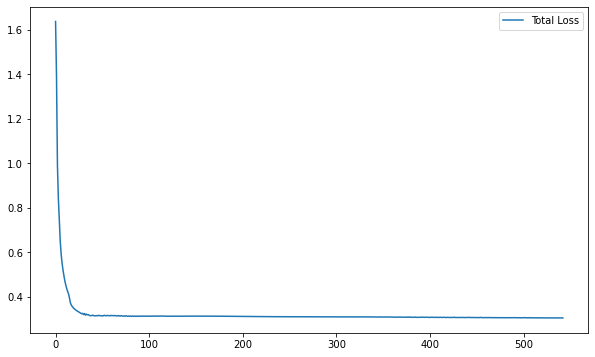

In [17]:
#----- Plotting losses ---------------
loss_dict = {}
#loss_dict['Reconstruction Loss'] = train_recons_loss_list
#loss_dict['View_Reconstruction Loss'] = view_recons_loss_list
#loss_dict['Prediction Loss'] = train_pred_loss_list
loss_dict['Total Loss'] = train_loss_list
plot_losses(epoch+1, loss_dict)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

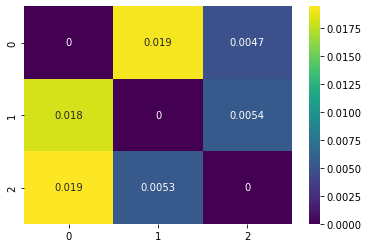

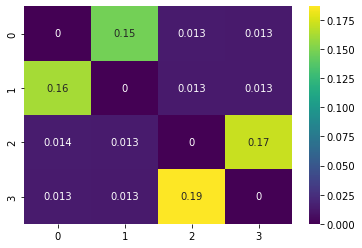

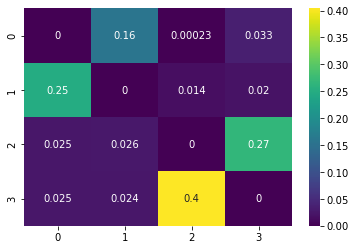

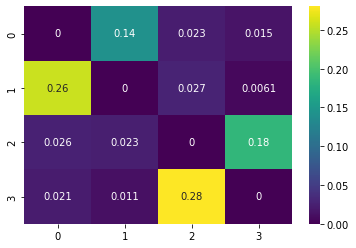

In [19]:
A = mv_model.view_attn.detach().numpy()
A = np.absolute(A)
sns.heatmap(A, cmap='viridis', annot = True)
plt.show()

for per_view_attention in mv_model.per_view_attns:
      A = per_view_attention.detach().numpy()
      A = np.abs(A)
      sns.heatmap(A, cmap='viridis', annot = True)
      plt.show()